In [1]:
run_for_size = 20000

- Can experiment with the type of stemmer / lemmatizer
- Can experiment with various vectorization methods (Count vectorizer, n-grams, TF-IDF and more)
- Can experiment with feature engineering
- Can experiment with different ML models
- Can experiment with different hyperparameters

In [2]:
import pandas as pd
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import joblib
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from scikeras.wrappers import KerasClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import fasttext
import fasttext.util
from gensim.models import KeyedVectors
from gensim.models.fasttext import load_facebook_vectors
nltk.download('punkt')
nltk.download('wordnet')

/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gurleenkaur/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gurleenkaur/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# fasttext.util.download_model('en', if_exists='ignore')
# ft = fasttext.load_model('cc.en.300.bin')
# ft.get_dimension()
# ft.save_model('cc.en.300.bin')

### Data source: https://www.kaggle.com/datasets/bittlingmayer/amazonreviews?rvi=1

\__label__1: negative review  
\__label__2: positive review

In [4]:
pos_label = '__label__1'

# Load and parse data

In [5]:
raw_data = open('train.ft.txt').read()
raw_data[:100]

'__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in y'

In [6]:
raw_data_list = raw_data.split('\n')
raw_data_list[:3]

['__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^',
 "__label__2 The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.",
 '__label__2 Amazing!: This sound

In [7]:
label_list = []
body_list = []
for item in raw_data_list:
    try:
        match_obj = re.search('(__label__[12])(.*)', item)
        label_list.append(match_obj.group(1))
        body_list.append(match_obj.group(2))    
    except:
        print(item, end="\n")

In [8]:
print(f"Number of labels: {len(label_list)}")
print(f"Number of reviews: {len(body_list)}")

Number of labels: 3600000
Number of reviews: 3600000


In [9]:
df = pd.DataFrame({'Labels': label_list, 'Reviews': body_list})
df.head()

,Labels,Reviews
0,__label__2,Stuning even for the non-gamer: This sound tr...
1,__label__2,The best soundtrack ever to anything.: I'm re...
2,__label__2,Amazing!: This soundtrack is my favorite musi...
3,__label__2,Excellent Soundtrack: I truly like this sound...
4,__label__2,"Remember, Pull Your Jaw Off The Floor After H..."


In [10]:
df.shape

(3600000, 2)

In [11]:
df = df.sample(n=run_for_size)
df.reset_index(inplace=True, drop=True)
df.head()

,Labels,Reviews
0,__label__2,An Enjoyable Experience: I usually don't writ...
1,__label__2,wow: What an excellent novel! I recommend thi...
2,__label__1,Worst Potter films yet: This has surely got t...
3,__label__2,Dad is Pleased!: Having purchased this for my...
4,__label__1,"Oh By The Way, Which One's Pink?: Back in 198..."


In [12]:
df.shape

(20000, 2)

# Clean Data

- Covert text to lower case
- Remove punctuations
- Tokenization
- Remove stopwords
- Stemming / Lemmatizing

### Covert text to lower case and remove punctuations

In [13]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [14]:
def lower_case_and_remove_punct(text):
    new_text = [ch.lower() for ch in text if ch not in string.punctuation]
    return "".join(new_text)

In [15]:
df['lower_case_and_punct_removed_reviews'] = df['Reviews'].apply(lambda x: lower_case_and_remove_punct(x))

In [16]:
df.head()

,Labels,Reviews,lower_case_and_punct_removed_reviews
0,__label__2,An Enjoyable Experience: I usually don't writ...,an enjoyable experience i usually dont write ...
1,__label__2,wow: What an excellent novel! I recommend thi...,wow what an excellent novel i recommend this ...
2,__label__1,Worst Potter films yet: This has surely got t...,worst potter films yet this has surely got to...
3,__label__2,Dad is Pleased!: Having purchased this for my...,dad is pleased having purchased this for my q...
4,__label__1,"Oh By The Way, Which One's Pink?: Back in 198...",oh by the way which ones pink back in 1987 ro...


### Tokenize

In [17]:
df['tokenized_reviews'] = df['lower_case_and_punct_removed_reviews'].apply(lambda x: word_tokenize(x))

In [18]:
df.head()

,Labels,Reviews,lower_case_and_punct_removed_reviews,tokenized_reviews
0,__label__2,An Enjoyable Experience: I usually don't writ...,an enjoyable experience i usually dont write ...,"[an, enjoyable, experience, i, usually, dont, ..."
1,__label__2,wow: What an excellent novel! I recommend thi...,wow what an excellent novel i recommend this ...,"[wow, what, an, excellent, novel, i, recommend..."
2,__label__1,Worst Potter films yet: This has surely got t...,worst potter films yet this has surely got to...,"[worst, potter, films, yet, this, has, surely,..."
3,__label__2,Dad is Pleased!: Having purchased this for my...,dad is pleased having purchased this for my q...,"[dad, is, pleased, having, purchased, this, fo..."
4,__label__1,"Oh By The Way, Which One's Pink?: Back in 198...",oh by the way which ones pink back in 1987 ro...,"[oh, by, the, way, which, ones, pink, back, in..."


### Remove stopwords

In [19]:
stop_words = set(stopwords.words('english'))
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [20]:
def remove_stopwords(text):
    new_text = [word for word in text if word not in stop_words]
    return new_text

In [21]:
df['stopwords_removed_reviews'] = df['tokenized_reviews'].apply(lambda x: remove_stopwords(x))

### Stemming

Choosing stemming over lemmatization because the dataset is huge and lemmatization is more computationally expensive as compared to stemming.

In [22]:
porterStemmer = PorterStemmer()
def apply_stemming(text):
    new_text = [porterStemmer.stem(word) for word in text]
    return new_text

In [23]:
df['stemmed_reviews'] = df['stopwords_removed_reviews'].apply(lambda x: apply_stemming(x))

In [24]:
df.head()

,Labels,Reviews,lower_case_and_punct_removed_reviews,tokenized_reviews,stopwords_removed_reviews,stemmed_reviews
0,__label__2,An Enjoyable Experience: I usually don't writ...,an enjoyable experience i usually dont write ...,"[an, enjoyable, experience, i, usually, dont, ...","[enjoyable, experience, usually, dont, write, ...","[enjoy, experi, usual, dont, write, review, fe..."
1,__label__2,wow: What an excellent novel! I recommend thi...,wow what an excellent novel i recommend this ...,"[wow, what, an, excellent, novel, i, recommend...","[wow, excellent, novel, recommend, book, clubs...","[wow, excel, novel, recommend, book, club, wan..."
2,__label__1,Worst Potter films yet: This has surely got t...,worst potter films yet this has surely got to...,"[worst, potter, films, yet, this, has, surely,...","[worst, potter, films, yet, surely, got, worst...","[worst, potter, film, yet, sure, got, worst, 3..."
3,__label__2,Dad is Pleased!: Having purchased this for my...,dad is pleased having purchased this for my q...,"[dad, is, pleased, having, purchased, this, fo...","[dad, pleased, purchased, quite, elderly, fath...","[dad, pleas, purchas, quit, elderli, father, b..."
4,__label__1,"Oh By The Way, Which One's Pink?: Back in 198...",oh by the way which ones pink back in 1987 ro...,"[oh, by, the, way, which, ones, pink, back, in...","[oh, way, ones, pink, back, 1987, roger, water...","[oh, way, one, pink, back, 1987, roger, water,..."


In [25]:
df.to_csv('df.csv')

The above steps of cleaning text (tokenization, punctuation and stopwords removal, stemming, etc.) were performed to get an idea of how the cleaned text looks like. For the model, I'll create only one function (clean_text()) that will perform all the cleaning steps and will be passed to the vectorizing function.

# Vectorizing

- Count vectorization
- TF-IDF

In [26]:
def clean_text(text):
    lower_case_punct_removed = "".join([ch.lower() for ch in text if ch not in string.punctuation])
    tokenized_text = word_tokenize(lower_case_punct_removed)
    final_text = []
    for word in tokenized_text:
        if word not in stop_words:
            final_text.append(porterStemmer.stem(word))
    return " ".join(final_text)

In [27]:
df['FinalCleanedReviews'] = df['Reviews'].apply(clean_text)

### Count vectorization (using stemming)

In [28]:
countVectorizer = CountVectorizer()
X_train_count_v = countVectorizer.fit_transform(df['FinalCleanedReviews'])
joblib.dump(countVectorizer, 'countVectorizer.pkl')

# Expand the sparse matrix.
X_train_count_v_df = pd.DataFrame(X_train_count_v.toarray())
X_train_count_v_df.columns = countVectorizer.get_feature_names_out()
X_train_count_v_df.to_csv('X_train_count_v_df.csv')
X_train_count_v_df.head()

,00,000041,0003,0004065,0004165,00049,001,0014,002,003,...,él,électriqu,époqueil,érudit,ésta,éternel,étrang,été,últimament,único
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### TF-IDF (using stemming)

In [29]:
tfidfVectorizer = TfidfVectorizer()
X_train_tfidf_v = tfidfVectorizer.fit_transform(df['FinalCleanedReviews'])
joblib.dump(tfidfVectorizer, 'tfidfVectorizer.pkl')

# Expand the sparse matrix.
X_train_tfidf_v_df = pd.DataFrame(X_train_tfidf_v.toarray())
X_train_tfidf_v_df.columns = tfidfVectorizer.get_feature_names_out()
X_train_tfidf_v_df.to_csv('X_train_tfidf_v_df.csv')
X_train_tfidf_v_df.head()

,00,000041,0003,0004065,0004165,00049,001,0014,002,003,...,él,électriqu,époqueil,érudit,ésta,éternel,étrang,été,últimament,único
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Feature Engineering

# Machine Learning classifiers

- Ude grid-search-cv (Combination of hyperparameter tuning and cross validation)
- Compare different models performance (precision / recall / accuracy / any other metrics)

In [30]:
model_names_list = []
acc_list = []
precision_list = []
recall_list = []

### Perorming hyperparameter tuning and grid search using TF-IDF VECTORIZATION

In [31]:
X = X_train_tfidf_v
y = df['Labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Random Forest (with TF-IDF vectorization)

In [32]:
rf_tf_idf_classifier = RandomForestClassifier(random_state=42)

rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 6, 10],
    'min_samples_leaf': [1, 3, 5],
}

grid_search_rf_tf_idf = GridSearchCV(estimator=rf_tf_idf_classifier, param_grid=rf_params, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf_tf_idf.fit(X_train, y_train)
best_rf_tf_idf = grid_search_rf_tf_idf.best_estimator_
joblib.dump(best_rf_tf_idf, 'best_rf_tf_idf.pkl')
print("Best Hyperparameters:")
print(grid_search_rf_tf_idf.best_params_)

y_pred = best_rf_tf_idf.predict(X_test)

accuracy_rf_tf_idf = accuracy_score(y_test, y_pred)
precision_rf_tf_idf = precision_score(y_test, y_pred, pos_label=pos_label)
recall_rf_tf_idf = recall_score(y_test, y_pred, pos_label=pos_label)

print(f"Accuracy: {accuracy_rf_tf_idf:.4f}")
print(f"Precision: {precision_rf_tf_idf:.4f}")
print(f"Recall: {recall_rf_tf_idf:.4f}")

model_names_list.append('RANDOM FOREST (with TF-IDF)')
acc_list.append(accuracy_rf_tf_idf)
precision_list.append(precision_rf_tf_idf)
recall_list.append(recall_rf_tf_idf)

Best Hyperparameters:
{'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 300}
Accuracy: 0.8492
Precision: 0.8373
Recall: 0.8575


### Gradient Boosting (with TF-IDF vectorization)

In [33]:
gb_tf_idf_classifier = GradientBoostingClassifier(random_state=42)

gb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [2, 3, 5],
}

grid_search_gb_tf_idf = GridSearchCV(estimator=gb_tf_idf_classifier, param_grid=gb_params, cv=5, scoring='accuracy', n_jobs=-1)

grid_search_gb_tf_idf.fit(X_train, y_train)

best_gb_tf_idf = grid_search_gb_tf_idf.best_estimator_
joblib.dump(best_gb_tf_idf, 'best_gb_tf_idf.pkl')

print("Best Hyperparameters:")
print(grid_search_gb_tf_idf.best_params_)

y_pred = best_gb_tf_idf.predict(X_test)

accuracy_gb_tf_idf = accuracy_score(y_test, y_pred)
precision_gb_tf_idf = precision_score(y_test, y_pred, pos_label=pos_label)
recall_gb_tf_idf = recall_score(y_test, y_pred, pos_label=pos_label)

print(f"Accuracy: {accuracy_gb_tf_idf:.4f}")
print(f"Precision: {precision_gb_tf_idf:.4f}")
print(f"Recall: {recall_gb_tf_idf:.4f}")

model_names_list.append('GRADIENT BOOSTING (with TF-IDF)')
acc_list.append(accuracy_gb_tf_idf)
precision_list.append(precision_gb_tf_idf)
recall_list.append(recall_gb_tf_idf)

Best Hyperparameters:
{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300}
Accuracy: 0.8415
Precision: 0.8317
Recall: 0.8462


### Naive Bayes (with TF-IDF vectorization)

In [34]:
nb_tf_idf_classifier = MultinomialNB()

nb_params = {
    'alpha': [0.01, 0.1, 1.0],
}

nb_tf_idf_classifier = MultinomialNB()

grid_search_nb_tf_idf = GridSearchCV(estimator=nb_tf_idf_classifier, param_grid=nb_params, cv=5, scoring='accuracy', n_jobs=-1)

grid_search_nb_tf_idf.fit(X_train, y_train)

best_nb_tf_idf_classifier = grid_search_nb_tf_idf.best_estimator_
joblib.dump(best_nb_tf_idf_classifier, 'best_nb_tf_idf_classifier.pkl')

print("Best Hyperparameters:")
print(grid_search_nb_tf_idf.best_params_)

y_pred = best_nb_tf_idf_classifier.predict(X_test)

accuracy_nb_tf_idf = accuracy_score(y_test, y_pred)
precision_nb_tf_idf = precision_score(y_test, y_pred, pos_label=pos_label)
recall_nb_tf_idf = recall_score(y_test, y_pred, pos_label=pos_label)

print(f"Accuracy: {accuracy_nb_tf_idf:.4f}")
print(f"Precision: {precision_nb_tf_idf:.4f}")
print(f"Recall: {recall_nb_tf_idf:.4f}")

model_names_list.append('NAIVE BAYES (with TF-IDF)')
acc_list.append(accuracy_nb_tf_idf)
precision_list.append(precision_nb_tf_idf)
recall_list.append(recall_nb_tf_idf)

Best Hyperparameters:
{'alpha': 1.0}
Accuracy: 0.8265
Precision: 0.8017
Recall: 0.8560


### Support Vector Machines (with TF-IDF vectorization)

In [35]:
svm_tf_idf_classifier = SVC()

svm_params = {
    'C': [0.1, 1.0, 10.0],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
}

grid_search_svm_tf_idf = GridSearchCV(estimator=svm_tf_idf_classifier, param_grid=svm_params, cv=5, scoring='accuracy', n_jobs=-1)

grid_search_svm_tf_idf.fit(X_train, y_train)

best_svm_tf_idf_classifier = grid_search_svm_tf_idf.best_estimator_
joblib.dump(best_svm_tf_idf_classifier, 'best_svm_tf_idf_classifier.pkl')

print("Best Hyperparameters:")
print(grid_search_svm_tf_idf.best_params_)

y_pred = best_svm_tf_idf_classifier.predict(X_test)

accuracy_svm_tf_idf = accuracy_score(y_test, y_pred)
precision_svm_tf_idf = precision_score(y_test, y_pred, pos_label=pos_label)
recall_svm_tf_idf = recall_score(y_test, y_pred, pos_label=pos_label)

print(f"Accuracy: {accuracy_svm_tf_idf:.4f}")
print(f"Precision: {precision_svm_tf_idf:.4f}")
print(f"Recall: {recall_svm_tf_idf:.4f}")

model_names_list.append('SVM (with TF-IDF)')
acc_list.append(accuracy_svm_tf_idf)
precision_list.append(precision_svm_tf_idf)
recall_list.append(recall_svm_tf_idf)


Best Hyperparameters:
{'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.8675
Precision: 0.8583
Recall: 0.8724


### Logistic Regression (with TF-IDF vectorization)

In [36]:
log_regr_tf_idf_classifier = LogisticRegression(solver='liblinear', max_iter=100)

log_regr_params = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2', None],
}

grid_search_log_regr_tf_idf = GridSearchCV(estimator=log_regr_tf_idf_classifier, param_grid=log_regr_params, cv=5, scoring='accuracy', n_jobs=-1)

grid_search_log_regr_tf_idf.fit(X_train, y_train)

best_log_regr_tf_idf_classifier = grid_search_log_regr_tf_idf.best_estimator_
joblib.dump(best_log_regr_tf_idf_classifier, 'best_log_regr_tf_idf_classifier.pkl')

print("Best Hyperparameters:")
print(grid_search_log_regr_tf_idf.best_params_)

y_pred = best_log_regr_tf_idf_classifier.predict(X_test)

accuracy_log_regr_tf_idf = accuracy_score(y_test, y_pred)
precision_log_regr_tf_idf = precision_score(y_test, y_pred, pos_label=pos_label)
recall_log_regr_tf_idf = recall_score(y_test, y_pred, pos_label=pos_label)

print(f"Accuracy: {accuracy_log_regr_tf_idf:.4f}")
print(f"Precision: {precision_log_regr_tf_idf:.4f}")
print(f"Recall: {recall_log_regr_tf_idf:.4f}")

model_names_list.append('LOGISTIC REGRESSION (with TF-IDF)')
acc_list.append(accuracy_log_regr_tf_idf)
precision_list.append(precision_log_regr_tf_idf)
recall_list.append(recall_log_regr_tf_idf)


/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/sklearn/base.py", line 1152, in wrapp

Best Hyperparameters:
{'C': 1.0, 'penalty': 'l2'}
Accuracy: 0.8668
Precision: 0.8559
Recall: 0.8739


### Perorming hyperparameter tuning and grid search using COUNT VECTORIZATION

In [37]:
X = X_train_count_v
y = df['Labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Random Forest (with count vectorization)

In [38]:
rf_count_classifier = RandomForestClassifier(random_state=42)

grid_search_rf_count = GridSearchCV(estimator=rf_count_classifier, param_grid=rf_params, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf_count.fit(X_train, y_train)
best_rf_count = grid_search_rf_count.best_estimator_
joblib.dump(best_rf_count, 'best_rf_count.pkl')
print("Best Hyperparameters:")
print(grid_search_rf_count.best_params_)

y_pred = best_rf_count.predict(X_test)

accuracy_rf_count = accuracy_score(y_test, y_pred)
precision_rf_count = precision_score(y_test, y_pred, pos_label=pos_label)
recall_rf_count = recall_score(y_test, y_pred, pos_label=pos_label)

print(f"Accuracy: {accuracy_rf_count:.4f}")
print(f"Precision: {precision_rf_count:.4f}")
print(f"Recall: {recall_rf_count:.4f}")

model_names_list.append('RANDOM FOREST (with Count Vectorization)')
acc_list.append(accuracy_rf_count)
precision_list.append(precision_rf_count)
recall_list.append(recall_rf_count)


Best Hyperparameters:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 300}
Accuracy: 0.8480
Precision: 0.8356
Recall: 0.8570


### Gradient Boosting (with count vectorization)

In [39]:
gb_count_classifier = GradientBoostingClassifier(random_state=42)

grid_search_gb_count = GridSearchCV(estimator=gb_count_classifier, param_grid=gb_params, cv=5, scoring='accuracy', n_jobs=-1)

grid_search_gb_count.fit(X_train, y_train)

best_gb_count = grid_search_gb_count.best_estimator_
joblib.dump(best_gb_count, 'best_gb_count.pkl')

print("Best Hyperparameters:")
print(grid_search_gb_count.best_params_)

y_pred = best_gb_count.predict(X_test)

accuracy_gb_count = accuracy_score(y_test, y_pred)
precision_gb_count = precision_score(y_test, y_pred, pos_label=pos_label)
recall_gb_count = recall_score(y_test, y_pred, pos_label=pos_label)

print(f"Accuracy: {accuracy_gb_count:.4f}")
print(f"Precision: {precision_gb_count:.4f}")
print(f"Recall: {recall_gb_count:.4f}")

model_names_list.append('GRADIENT BOOSTING (with Count Vectorization)')
acc_list.append(accuracy_gb_count)
precision_list.append(precision_gb_count)
recall_list.append(recall_gb_count)


/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Best Hyperparameters:
{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300}
Accuracy: 0.8510
Precision: 0.8423
Recall: 0.8544


### Naive Bayes (with count vectorization)

In [40]:
nb_count_classifier = MultinomialNB()

nb_count_classifier = MultinomialNB()

grid_search_nb_count = GridSearchCV(estimator=nb_count_classifier, param_grid=nb_params, cv=5, scoring='accuracy', n_jobs=-1)

grid_search_nb_count.fit(X_train, y_train)

best_nb_count_classifier = grid_search_nb_count.best_estimator_
joblib.dump(best_nb_count_classifier, 'best_nb_count_classifier.pkl')

print("Best Hyperparameters:")
print(grid_search_nb_count.best_params_)

y_pred = best_nb_count_classifier.predict(X_test)

accuracy_nb_count = accuracy_score(y_test, y_pred)
precision_nb_count = precision_score(y_test, y_pred, pos_label=pos_label)
recall_nb_count = recall_score(y_test, y_pred, pos_label=pos_label)

print(f"Accuracy: {accuracy_nb_count:.4f}")
print(f"Precision: {precision_nb_count:.4f}")
print(f"Recall: {recall_nb_count:.4f}")

model_names_list.append('NAIVE BAYES (with Count Vectorization)')
acc_list.append(accuracy_nb_count)
precision_list.append(precision_nb_count)
recall_list.append(recall_nb_count)


Best Hyperparameters:
{'alpha': 1.0}
Accuracy: 0.8265
Precision: 0.8095
Recall: 0.8426


### Support Vector Machines (with count vectorization)

In [41]:
svm_count_classifier = SVC()

grid_search_svm_count = GridSearchCV(estimator=svm_count_classifier, param_grid=svm_params, cv=5, scoring='accuracy', n_jobs=-1)

grid_search_svm_count.fit(X_train, y_train)

best_svm_count_classifier = grid_search_svm_count.best_estimator_
joblib.dump(best_svm_count_classifier, 'best_svm_count_classifier.pkl')

print("Best Hyperparameters:")
print(grid_search_svm_count.best_params_)

y_pred = best_svm_count_classifier.predict(X_test)

accuracy_svm_count = accuracy_score(y_test, y_pred)
precision_svm_count = precision_score(y_test, y_pred, pos_label=pos_label)
recall_svm_count = recall_score(y_test, y_pred, pos_label=pos_label)

print(f"Accuracy: {accuracy_svm_count:.4f}")
print(f"Precision: {precision_svm_count:.4f}")
print(f"Recall: {recall_svm_count:.4f}")

model_names_list.append('SVM (with Count Vectorization)')
acc_list.append(accuracy_svm_count)
precision_list.append(precision_svm_count)
recall_list.append(recall_svm_count)


/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Best Hyperparameters:
{'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.8590
Precision: 0.8487
Recall: 0.8652


### Logistic Regression (with count vectorization)

In [42]:
log_regr_count_classifier = LogisticRegression(solver='liblinear', max_iter=100)

grid_search_log_regr_count = GridSearchCV(estimator=log_regr_count_classifier, param_grid=log_regr_params, cv=5, scoring='accuracy', n_jobs=-1)

grid_search_log_regr_count.fit(X_train, y_train)

best_log_regr_count_classifier = grid_search_log_regr_count.best_estimator_
joblib.dump(best_log_regr_count_classifier, 'best_log_regr_count_classifier.pkl')

print("Best Hyperparameters:")
print(grid_search_log_regr_count.best_params_)

y_pred = best_log_regr_count_classifier.predict(X_test)

accuracy_log_regr_count = accuracy_score(y_test, y_pred)
precision_log_regr_count = precision_score(y_test, y_pred, pos_label=pos_label)
recall_log_regr_count = recall_score(y_test, y_pred, pos_label=pos_label)

print(f"Accuracy: {accuracy_log_regr_count:.4f}")
print(f"Precision: {precision_log_regr_count:.4f}")
print(f"Recall: {recall_log_regr_count:.4f}")

model_names_list.append('LOGISTIC REGRESSION (with Count Vectorization)')
acc_list.append(accuracy_log_regr_count)
precision_list.append(precision_log_regr_count)
recall_list.append(recall_log_regr_count)


/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/sklearn/base.py", line 1152, in wrapp

Best Hyperparameters:
{'C': 0.1, 'penalty': 'l2'}
Accuracy: 0.8618
Precision: 0.8530
Recall: 0.8657


## Deep Learning Models

### LSTM

In [43]:
X = df['FinalCleanedReviews'].values
y = df['Labels'].values
y[y=='__label__1'] = 0
y[y=='__label__2'] = 1
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

total_words_size = len(tokenizer.word_index) + 1

longest_text_len = df['FinalCleanedReviews'].apply(lambda x: len(x)).max()
X_train = pad_sequences(X_train, maxlen=longest_text_len, padding='post')
X_test = pad_sequences(X_test, maxlen=longest_text_len, padding='post')

### LSTM (without word embeddings)

In [45]:
X = df['FinalCleanedReviews'].values
y = df['Labels'].values
y[y=='__label__1'] = 0
y[y=='__label__2'] = 1
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

total_words_size = len(tokenizer.word_index) + 1

longest_text_len = df['FinalCleanedReviews'].apply(lambda x: len(x)).max()
X_train = pad_sequences(X_train, maxlen=longest_text_len, padding='post')
X_test = pad_sequences(X_test, maxlen=longest_text_len, padding='post')

lstm_params = {
    'units': [50, 100, 150],
    'dropout_rate': [0.2, 0.3, 0.1],
    'embedding_dim': [50, 100, 200]
}

def get_lstm_model(units, dropout_rate, embedding_dim):

    lstm_model = Sequential()
    lstm_model.add(Embedding(input_dim=total_words_size, output_dim=embedding_dim, input_length=longest_text_len))
    lstm_model.add(LSTM(units=units, dropout=dropout_rate))
    lstm_model.add(Dense(1, activation='sigmoid'))
    lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return lstm_model


lstm_model = KerasClassifier(build_fn=get_lstm_model, units=50, dropout_rate=0.2, embedding_dim=50)

grid_search_lstm = GridSearchCV(estimator=lstm_model, param_grid=lstm_params, cv=2, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search_lstm.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search_lstm.best_params_)

best_model_wrapper = grid_search_lstm.best_estimator_
best_lstm_model = best_model_wrapper.build_fn(best_model_wrapper.get_params()['units'], best_model_wrapper.get_params()['dropout_rate'], best_model_wrapper.get_params()['embedding_dim'])

best_lstm_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1)
joblib.dump(best_lstm_model, 'best_lstm_model.pkl')

y_pred = best_lstm_model.predict(X_test)
y_pred = (y_pred>0.5).astype(int)

precision_lstm = precision_score(y_test, y_pred)
recall_lstm = recall_score(y_test, y_pred)
accuracy_lstm = accuracy_score(y_test, y_pred)

print(f"Precision: {precision_lstm}")
print(f"Recall: {recall_lstm}")
print(f"Accuracy: {accuracy_lstm}")

model_names_list.append('LSTM')
acc_list.append(accuracy_lstm)
precision_list.append(precision_lstm)
recall_list.append(recall_lstm)

Fitting 2 folds for each of 27 candidates, totalling 54 fits
212/250 [========================>.....] - ETA: 8s

/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Dom

250/250 [==============================] - 53s 212ms/step


/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


 39/500 [=>............................] - ETA: 1:04 - loss: 0.6939 - accuracy: 0.4936

/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Dom

316/500 [=================>............] - ETA: 24s - loss: 0.6935 - accuracy: 0.4998

/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Dom

361/500 [====================>.........] - ETA: 18s - loss: 0.6935 - accuracy: 0.4999

/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Dom

500/500 [==============================] - 69s 136ms/step - loss: 0.6934 - accuracy: 0.4988
Best Hyperparameters: {'dropout_rate': 0.2, 'embedding_dim': 50, 'units': 50}
Epoch 1/10
225/225 [==============================] - 47s 207ms/step - loss: 0.6936 - accuracy: 0.4974 - val_loss: 0.6930 - val_accuracy: 0.5100
Epoch 2/10
157/225 [===================>..........] - ETA: 13s - loss: 0.6932 - accuracy: 0.5036

/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Dom

225/225 [==============================] - 46s 206ms/step - loss: 0.6932 - accuracy: 0.5018 - val_loss: 0.6930 - val_accuracy: 0.5100
Epoch 3/10
  1/225 [..............................] - ETA: 44s - loss: 0.6932 - accuracy: 0.5000

/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Dom

 84/225 [==========>...................] - ETA: 27s - loss: 0.6933 - accuracy: 0.4970

/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Dom

146/225 [==================>...........] - ETA: 15s - loss: 0.6933 - accuracy: 0.4951

/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Dom

225/225 [==============================] - 46s 205ms/step - loss: 0.6933 - accuracy: 0.4919 - val_loss: 0.6931 - val_accuracy: 0.5100
Epoch 4/10
225/225 [==============================] - 46s 204ms/step - loss: 0.6932 - accuracy: 0.4926 - val_loss: 0.6936 - val_accuracy: 0.4900
Epoch 5/10
160/225 [====================>.........] - ETA: 12s - loss: 0.6933 - accuracy: 0.5021

/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Dom

225/225 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5002

/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Dom

225/225 [==============================] - 46s 204ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6934 - val_accuracy: 0.4900
Epoch 6/10
225/225 [==============================] - 46s 202ms/step - loss: 0.6932 - accuracy: 0.5054 - val_loss: 0.6931 - val_accuracy: 0.5100
Epoch 7/10
225/225 [==============================] - 46s 206ms/step - loss: 0.6932 - accuracy: 0.4915 - val_loss: 0.6931 - val_accuracy: 0.5100
Epoch 8/10
225/225 [==============================] - 46s 204ms/step - loss: 0.6932 - accuracy: 0.4964 - val_loss: 0.6932 - val_accuracy: 0.4900
Epoch 9/10
225/225 [==============================] - 46s 205ms/step - loss: 0.6932 - accuracy: 0.5007 - val_loss: 0.6935 - val_accuracy: 0.4900
Epoch 10/10
225/225 [==============================] - 46s 205ms/step - loss: 0.6932 - accuracy: 0.4995 - val_loss: 0.6933 - val_accuracy: 0.4900
INFO:tensorflow:Assets written to: ram://76be8082f0ea4eedb4aef7151d4a3f74/assets


INFO:tensorflow:Assets written to: ram://76be8082f0ea4eedb4aef7151d4a3f74/assets


125/125 [==============================] - 4s 33ms/step
Precision: 0.51225
Recall: 1.0
Accuracy: 0.51225


### LSTM (with word embeddings)

### 100 Embeddings

In [46]:
fasttext_model_path = 'cc.en.100.bin'
fasttext_model = load_facebook_vectors(fasttext_model_path)
embedding_dim = 100
embedding_matrix = np.zeros((total_words_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in fasttext_model:
        embedding_matrix[i] = fasttext_model[word]

def get_lstm_model_ft(units, dropout_rate, embedding_dim):

    lstm_model_ft = Sequential()
    lstm_model_ft.add(Embedding(input_dim=total_words_size, output_dim=embedding_dim, input_length=longest_text_len, weights=[embedding_matrix], trainable=False))
    lstm_model_ft.add(LSTM(units=units, dropout=dropout_rate))
    lstm_model_ft.add(Dense(1, activation='sigmoid'))
    lstm_model_ft.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return lstm_model_ft


lstm_model_ft = KerasClassifier(build_fn=get_lstm_model_ft, units=50, dropout_rate=0.2, embedding_dim=50)

grid_search_lstm_ft = GridSearchCV(estimator=lstm_model_ft, param_grid=lstm_params, cv=2, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search_lstm_ft.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search_lstm_ft.best_params_)

best_lstm_model_ft_wrapper = grid_search_lstm_ft.best_estimator_
best_lstm_model_ft = best_lstm_model_ft_wrapper.build_fn(best_lstm_model_ft_wrapper.get_params()['units'], best_lstm_model_ft_wrapper.get_params()['dropout_rate'], best_lstm_model_ft_wrapper.get_params()['embedding_dim'])

best_lstm_model_ft.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1)
joblib.dump(best_lstm_model_ft, 'best_lstm_model_ft.pkl')

y_pred = best_lstm_model_ft.predict(X_test)
y_pred = (y_pred>0.5).astype(int)

precision_lstm_ft = precision_score(y_test, y_pred)
recall_lstm_ft = recall_score(y_test, y_pred)
accuracy_lstm_ft = accuracy_score(y_test, y_pred)

print(f"Precision: {precision_lstm_ft}")
print(f"Recall: {recall_lstm_ft}")
print(f"Accuracy: {accuracy_lstm_ft}")

model_names_list.append('LSTM (with 100 word embeddings)')
acc_list.append(accuracy_lstm_ft)
precision_list.append(precision_lstm_ft)
recall_list.append(recall_lstm_ft)

Fitting 2 folds for each of 27 candidates, totalling 54 fits
250/250 [==============================] - 42s 165ms/step


/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
36 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py", line 1491, in f

215/500 [===========>..................] - ETA: 1:55 - loss: 0.6933 - accuracy: 0.4852

/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Dom

235/500 [=============>................] - ETA: 1:47 - loss: 0.6933 - accuracy: 0.4870

/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


300/500 [=================>............] - ETA: 1:20 - loss: 0.6933 - accuracy: 0.4926

/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Dom

359/500 [====================>.........] - ETA: 56s - loss: 0.6933 - accuracy: 0.4931

/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Dom

421/500 [========================>.....] - ETA: 31s - loss: 0.6933 - accuracy: 0.4919

/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


422/500 [========================>.....] - ETA: 31s - loss: 0.6933 - accuracy: 0.4919

/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


447/500 [=========================>....] - ETA: 21s - loss: 0.6933 - accuracy: 0.4918

/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


451/500 [==========================>...] - ETA: 19s - loss: 0.6933 - accuracy: 0.4908

/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Dom

500/500 [==============================] - 204s 407ms/step - loss: 0.6933 - accuracy: 0.4881
Best Hyperparameters: {'dropout_rate': 0.2, 'embedding_dim': 100, 'units': 150}
Epoch 1/10
115/225 [==============>...............] - ETA: 1:29 - loss: 0.6933 - accuracy: 0.4901

/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Dom

117/225 [==============>...............] - ETA: 1:27 - loss: 0.6932 - accuracy: 0.4903

/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Dom

225/225 [==============================] - 186s 827ms/step - loss: 0.6933 - accuracy: 0.4956 - val_loss: 0.6932 - val_accuracy: 0.4900
Epoch 2/10
225/225 [==============================] - 179s 798ms/step - loss: 0.6931 - accuracy: 0.5079 - val_loss: 0.6940 - val_accuracy: 0.4900
Epoch 3/10
225/225 [==============================] - 199s 884ms/step - loss: 0.6933 - accuracy: 0.5026 - val_loss: 0.6932 - val_accuracy: 0.4900
Epoch 4/10
225/225 [==============================] - 206s 917ms/step - loss: 0.6932 - accuracy: 0.4994 - val_loss: 0.6931 - val_accuracy: 0.5100
Epoch 5/10
225/225 [==============================] - 204s 907ms/step - loss: 0.6932 - accuracy: 0.4950 - val_loss: 0.6933 - val_accuracy: 0.4900
Epoch 6/10
225/225 [==============================] - 181s 805ms/step - loss: 0.6932 - accuracy: 0.5026 - val_loss: 0.6932 - val_accuracy: 0.4900
Epoch 7/10
225/225 [==============================] - 182s 807ms/step - loss: 0.6932 - accuracy: 0.4960 - val_loss: 0.6934 - val_accura

INFO:tensorflow:Assets written to: ram://65de21db4f0b4b9e8cd94d1633125b96/assets


125/125 [==============================] - 20s 156ms/step
Precision: 0.51225
Recall: 1.0
Accuracy: 0.51225


### 300 Embeddings

In [49]:
fasttext_model_path = 'cc.en.300.bin'
fasttext_model = load_facebook_vectors(fasttext_model_path)
embedding_dim = 300
embedding_matrix = np.zeros((total_words_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in fasttext_model:
        embedding_matrix[i] = fasttext_model[word]
lstm_params = {
    'units': [50, 100, 150],
    'dropout_rate': [0.2, 0.3, 0.1],
    'embedding_dim': [100, 200, 300]
}

def get_lstm_model_ft(units, dropout_rate, embedding_dim):

    lstm_model_ft = Sequential()
    lstm_model_ft.add(Embedding(input_dim=total_words_size, output_dim=embedding_dim, input_length=longest_text_len, weights=[embedding_matrix], trainable=False))
    lstm_model_ft.add(LSTM(units=units, dropout=dropout_rate))
    lstm_model_ft.add(Dense(1, activation='sigmoid'))
    lstm_model_ft.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return lstm_model_ft


lstm_model_ft = KerasClassifier(build_fn=get_lstm_model_ft, units=50, dropout_rate=0.2, embedding_dim=50)

grid_search_lstm_ft = GridSearchCV(estimator=lstm_model_ft, param_grid=lstm_params, cv=2, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search_lstm_ft.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search_lstm_ft.best_params_)

best_lstm_model_ft_wrapper = grid_search_lstm_ft.best_estimator_
best_lstm_model_ft = best_lstm_model_ft_wrapper.build_fn(best_lstm_model_ft_wrapper.get_params()['units'], best_lstm_model_ft_wrapper.get_params()['dropout_rate'], best_lstm_model_ft_wrapper.get_params()['embedding_dim'])

best_lstm_model_ft.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1)
joblib.dump(best_lstm_model_ft, 'best_lstm_model_ft.pkl')

y_pred = best_lstm_model_ft.predict(X_test)
y_pred = (y_pred>0.5).astype(int)

precision_lstm_ft = precision_score(y_test, y_pred)
recall_lstm_ft = recall_score(y_test, y_pred)
accuracy_lstm_ft = accuracy_score(y_test, y_pred)

print(f"Precision: {precision_lstm_ft}")
print(f"Recall: {recall_lstm_ft}")
print(f"Accuracy: {accuracy_lstm_ft}")

model_names_list.append('LSTM (with 300 word embeddings)')
acc_list.append(accuracy_lstm_ft)
precision_list.append(precision_lstm_ft)
recall_list.append(recall_lstm_ft)

Fitting 2 folds for each of 27 candidates, totalling 54 fits
148/250 [================>.............] - ETA: 39s

/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Dom

246/250 [============================>.] - ETA: 1s

/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


248/250 [============================>.] - ETA: 0s0

/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


139/250 [===============>..............] - ETA: 46s

/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Dom

134/250 [===============>..............] - ETA: 49s

/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


250/250 [==============================] - 97s 386ms/step


/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Dom

250/250 [==============================] - 100s 397ms/step


/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
36 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py", line 1491, in f

500/500 [==============================] - 99s 196ms/step - loss: 0.6933 - accuracy: 0.5051
Best Hyperparameters: {'dropout_rate': 0.3, 'embedding_dim': 300, 'units': 50}
Epoch 1/10
 18/225 [=>............................] - ETA: 1:03 - loss: 0.6917 - accuracy: 0.5260

/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Dom

 34/225 [===>..........................] - ETA: 58s - loss: 0.6937 - accuracy: 0.5060

/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Dom

225/225 [==============================] - 72s 317ms/step - loss: 0.6934 - accuracy: 0.4958 - val_loss: 0.6933 - val_accuracy: 0.4900
Epoch 2/10
225/225 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4983

/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Domain-Agnostic-Sentiment-Analysis/sent-analysis-venv/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gurleenkaur/CodingWorkspace/Dom

225/225 [==============================] - 71s 316ms/step - loss: 0.6932 - accuracy: 0.4983 - val_loss: 0.6931 - val_accuracy: 0.5100
Epoch 3/10
225/225 [==============================] - 71s 315ms/step - loss: 0.6932 - accuracy: 0.5010 - val_loss: 0.6933 - val_accuracy: 0.4900
Epoch 4/10
225/225 [==============================] - 71s 316ms/step - loss: 0.6933 - accuracy: 0.4940 - val_loss: 0.6932 - val_accuracy: 0.4900
Epoch 5/10
225/225 [==============================] - 71s 316ms/step - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6931 - val_accuracy: 0.5100
Epoch 6/10
225/225 [==============================] - 71s 316ms/step - loss: 0.6932 - accuracy: 0.4972 - val_loss: 0.6933 - val_accuracy: 0.4900
Epoch 7/10
225/225 [==============================] - 71s 317ms/step - loss: 0.6932 - accuracy: 0.4983 - val_loss: 0.6933 - val_accuracy: 0.4900
Epoch 8/10
225/225 [==============================] - 71s 317ms/step - loss: 0.6932 - accuracy: 0.4993 - val_loss: 0.6933 - val_accuracy: 0.4

INFO:tensorflow:Assets written to: ram://7d3dd40929b5453cb75959db061b3455/assets


125/125 [==============================] - 10s 77ms/step
Precision: 0.51225
Recall: 1.0
Accuracy: 0.51225


# Performance analysis

In [50]:
(model_names_list, acc_list, precision_list, recall_list)
for i in range(len(model_names_list)):
    print(f"{model_names_list[i]}:\n Accuracy: {acc_list[i]}, Precision: {precision_list[i]}, Recall: {recall_list[i]}\n")

RANDOM FOREST (with TF-IDF):
 Accuracy: 0.84925, Precision: 0.8373373373373373, Recall: 0.8575089697590978

GRADIENT BOOSTING (with TF-IDF):
 Accuracy: 0.8415, Precision: 0.8317380352644836, Recall: 0.8462327011788826

NAIVE BAYES (with TF-IDF):
 Accuracy: 0.8265, Precision: 0.8017282765242438, Recall: 0.8559712967708867

SVM (with TF-IDF):
 Accuracy: 0.8675, Precision: 0.8582955118507312, Recall: 0.8723731419784726

LOGISTIC REGRESSION (with TF-IDF):
 Accuracy: 0.86675, Precision: 0.8559236947791165, Recall: 0.8739108149666838

RANDOM FOREST (with Count Vectorization):
 Accuracy: 0.848, Precision: 0.8355822088955522, Recall: 0.8569964120963608

GRADIENT BOOSTING (with Count Vectorization):
 Accuracy: 0.851, Precision: 0.842344618494189, Recall: 0.8544336237826755

NAIVE BAYES (with Count Vectorization):
 Accuracy: 0.8265, Precision: 0.8094534711964549, Recall: 0.8426447975397232

SVM (with Count Vectorization):
 Accuracy: 0.859, Precision: 0.8486676721970839, Recall: 0.865197334700153

### Accuracy comparision

/var/folders/6g/fytkkjps4bv8kzynbpd83_x80000gn/T/ipykernel_9249/2923915979.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=sorted_model_names, x=sorted_accuracies, orient="h", palette="viridis")


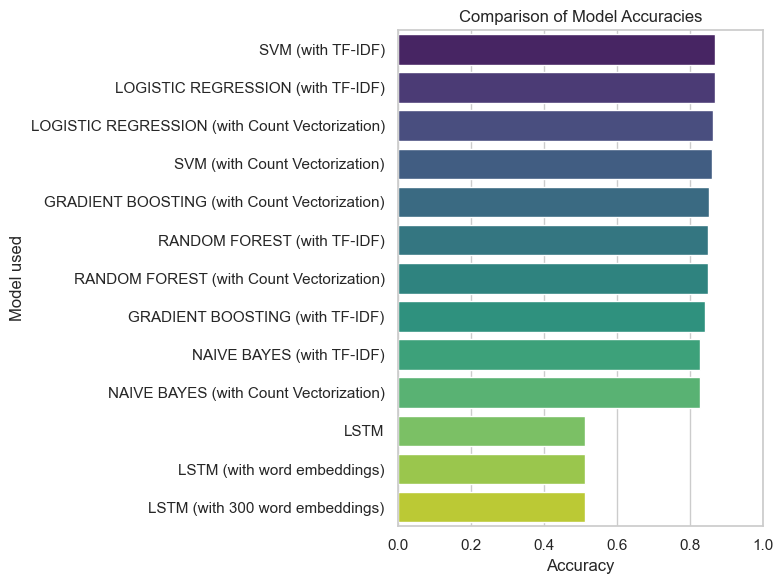

In [51]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

sorted_model_names, sorted_accuracies = zip(*sorted(zip(model_names_list, acc_list), key=lambda x: x[1], reverse=True))

sns.barplot(y=sorted_model_names, x=sorted_accuracies, orient="h", palette="viridis")

plt.ylabel('Model used')
plt.xlabel('Accuracy')
plt.title('Comparison of Model Accuracies')

plt.xlim(0, 1)
plt.tight_layout()
plt.show()

### Precision comparision

/var/folders/6g/fytkkjps4bv8kzynbpd83_x80000gn/T/ipykernel_9249/713413107.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=sorted_model_names, x=sorted_precisions, orient="h", palette="viridis")


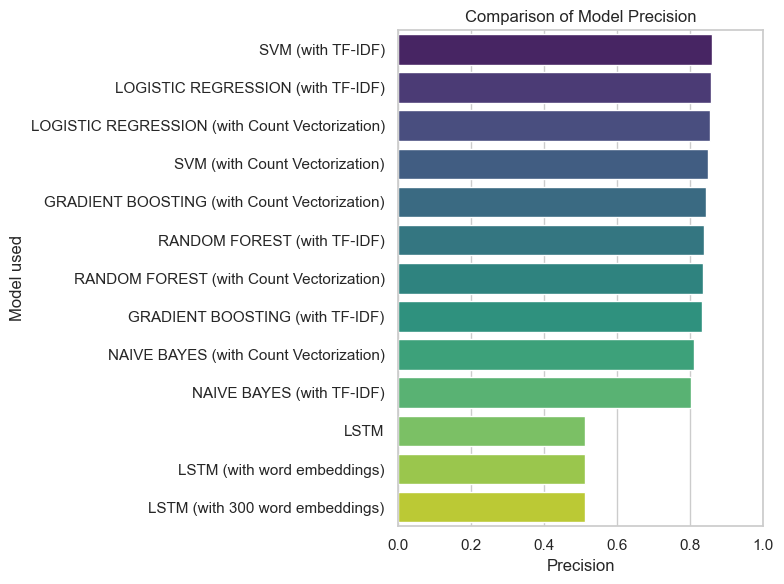

In [52]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

sorted_model_names, sorted_precisions = zip(*sorted(zip(model_names_list, precision_list), key=lambda x: x[1], reverse=True))

sns.barplot(y=sorted_model_names, x=sorted_precisions, orient="h", palette="viridis")

plt.ylabel('Model used')
plt.xlabel('Precision')
plt.title('Comparison of Model Precision')

plt.xlim(0, 1)
plt.tight_layout()
plt.show()

### Recall comparision

/var/folders/6g/fytkkjps4bv8kzynbpd83_x80000gn/T/ipykernel_9249/1082163913.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=sorted_model_names, x=sorted_recalls, orient="h", palette="viridis")


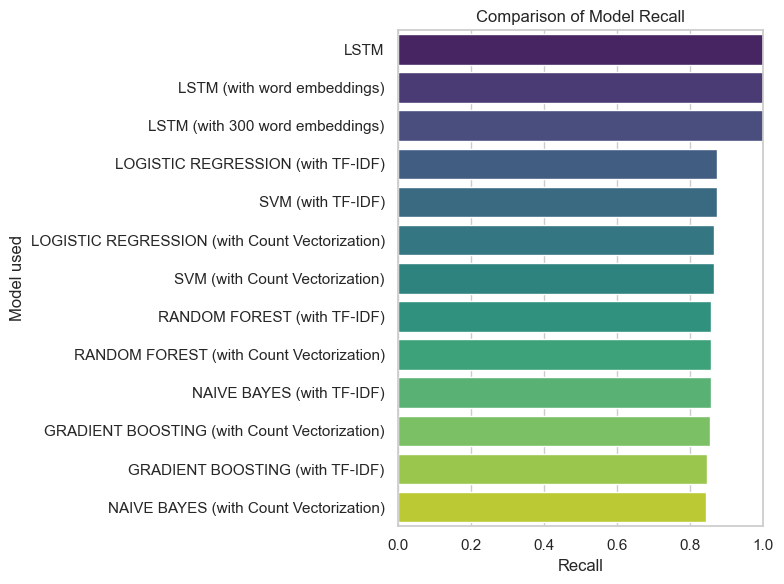

In [53]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

sorted_model_names, sorted_recalls = zip(*sorted(zip(model_names_list, recall_list), key=lambda x: x[1], reverse=True))

sns.barplot(y=sorted_model_names, x=sorted_recalls, orient="h", palette="viridis")

plt.ylabel('Model used')
plt.xlabel('Recall')
plt.title('Comparison of Model Recall')

plt.xlim(0, 1)
plt.tight_layout()
plt.show()